# Data    Analysis     Interview    Challenge - SOLUTION

****
*This     is     your     chance     to    wow     us    with     creative    and     rigorous     solutions!    Please     include     your     code     at  the    end     of     your     submission,     or     in     a     separate     file.    We also    accept     incomplete     solutions. *
****

## Part    1    ‑    Exploratory    data    analysis
The    attached       logins.json       file     contains     (simulated)     timestamps    of    user     logins     in    a    particular  geographic     location.     
1. Aggregate     these     login     counts    based    on    15­ minute     time     intervals 
2. Visualize     and    describe     the     resulting     time     series    of     login     counts     in    ways     that    best     characterize     the  underlying    patterns     of     the    demand.     
3. Please     report/illustrate     important     features    of     the    demand,  such     as    daily     cycles.     
4. If     there     are     data     quality     issues,    please     report     them.

In [1]:
# Imports libraries
import pandas as pd
%pylab inline
import json
from pandas.io.json import json_normalize

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Loading data and taking a shot
login_df = pd.read_json('D:/DADOS USUARIO/Documents/springboard/take-home exercises/ultimate_challenge/logins.json')
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [3]:
# Converting to time series dataframe
login_df['count'] = 1
login_df = login_df.set_index('login_time')
login_df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


### 1. Aggregate these login counts based on 15­ minute time intervals

In [4]:
login_df_15 = login_df.resample('15Min', label = 'right').sum()

### 2. Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

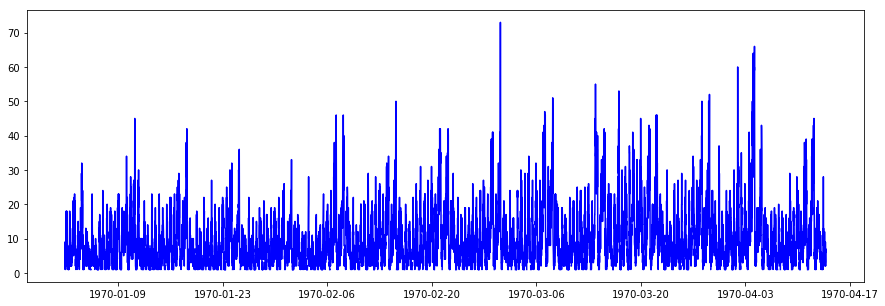

In [5]:
# Plotting the logins counts aggregated in 15 min
plt.figure(figsize=(15,5))
plt.plot(login_df_15, color = 'blue')

The line plot is quite dense. Sometimes it can help to change the style of the line plot; for example, to use dots. Let's check!

Text(0,0.5,'# logins')

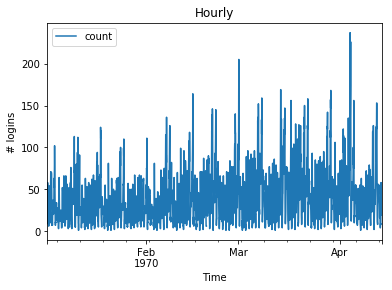

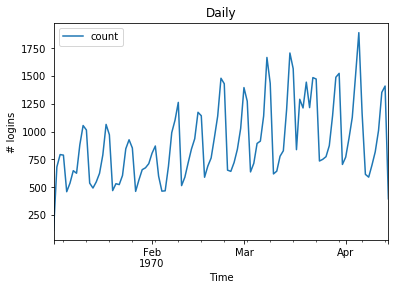

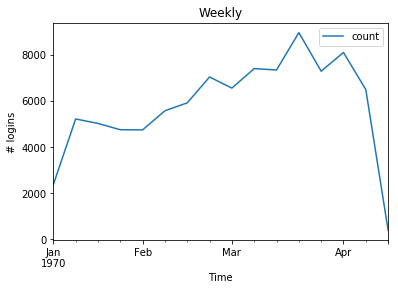

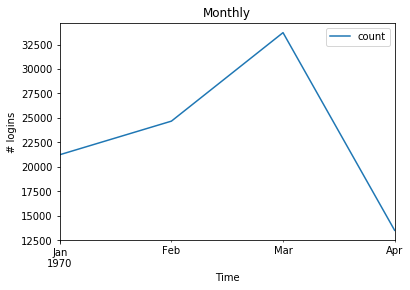

In [6]:
login_df_H = login_df.resample('H', label = 'right').sum()
login_df_D = login_df.resample('D', label = 'right').sum()
login_df_W = login_df.resample('W', label = 'right').sum()
login_df_M = login_df.resample('M', label = 'right').sum()

login_df_H.plot()
plt.title("Hourly")
plt.xlabel("Time")
plt.ylabel("# logins")

login_df_D.plot()
plt.title("Daily")
plt.xlabel("Time")
plt.ylabel("# logins")

login_df_W.plot()
plt.title("Weekly")
plt.xlabel("Time")
plt.ylabel("# logins")

login_df_M.plot()
plt.title("Monthly")
plt.xlabel("Time")
plt.ylabel("# logins")

There is a trend in this time series that it is not clear until you see the weekly or monthly chart.

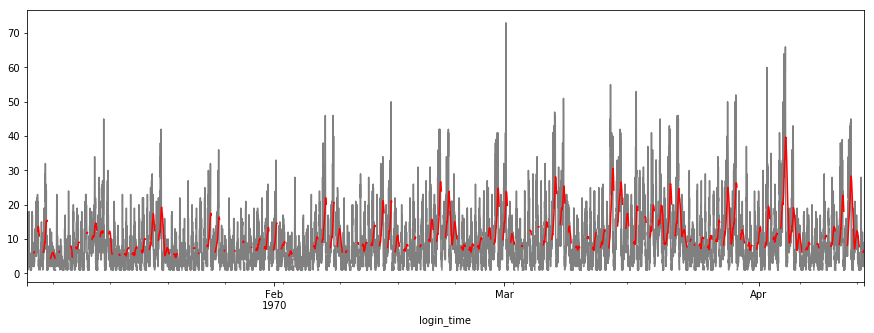

In [7]:
# Create and plotting a moving window of 40 periods
r = login_df_15.rolling(window=40)
plt.figure(figsize=(15,5))
login_df_15['count'].plot(color='gray')
r.mean()['count'].plot(color='red')

The peaks weren´t smoothed as expected and it is possible to see that the rolling window oftenly breaks. Showing that there is a problem with data regarding quality.

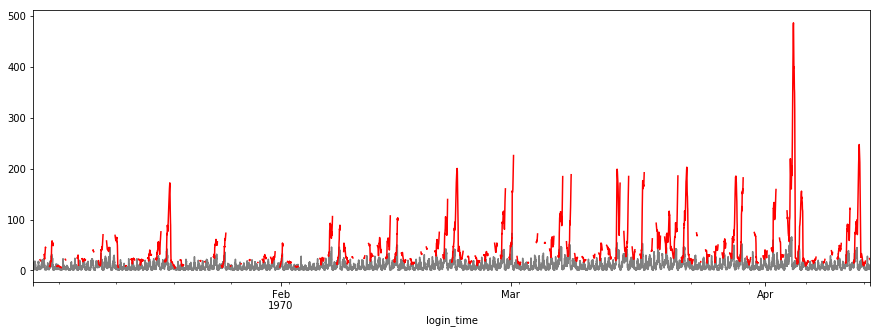

In [8]:
# Plot variance windows with 40 periods
plt.figure(figsize=(15,5))
login_df_15['count'].plot(color='gray')
r.var()['count'].plot(color='red')

As seen above there is a high variance in the data, so we need to get rid of it in order to see if there is internal patterns. To do this we will look at the difference between the current observations and previous using the lag function.

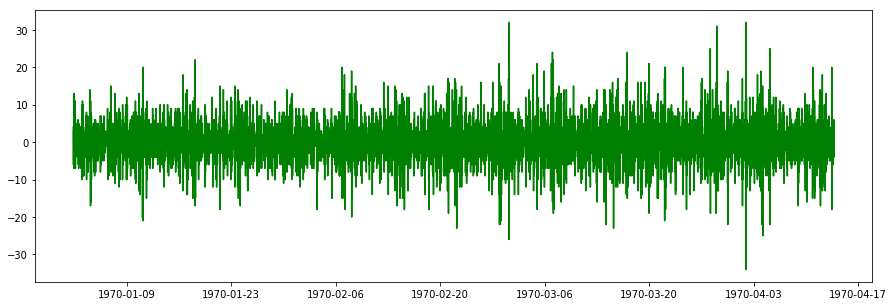

In [9]:
# Looking at the difference between the observations and previous through lag function
# Create a lag time series
ts_lagged = login_df_15.shift()
# Plot the difference between the time series and it's lag
plt.figure(figsize=(15,5))
plt.plot(login_df_15 - ts_lagged, color='green')

Now that we have the difference we can see that we are closer to stationary as we have detrended the data. So now we should look if there is correlation.

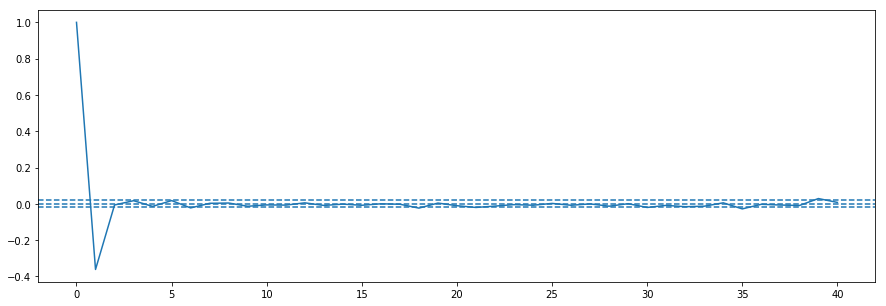

In [12]:
from statsmodels.tsa import stattools
login_df_15_diff = login_df_15 - login_df_15.shift()
acf_result = stattools.acf(login_df_15_diff.fillna(0))
plt.figure(figsize=(15,5))
plt.plot(acf_result)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(login_df_15_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(login_df_15_diff)),linestyle='--')

This plot shows that at 1 period of lag there is a negative self correlation of -0.3 and the reamining periods are within the confidence interval. And this is the internal structure of the data that we were looking for.

## Part    2    ‑    Experiment    and    metrics    design  

The    neighboring     cities    of    Gotham    and    Metropolis    have     complementary     circadian     rhythms:     on  weekdays,    Ultimate    Gotham     is    most     active    at    night,    and    Ultimate    Metropolis     is    most    active  during     the    day.    On    weekends,     there     is     reasonable    activity     in    both     cities.    

However,    a     toll    bridge,     with     a     two  ­way     toll,    between     the     two     cities     causes    driver    partners     to     tend  to    be    exclusive     to    each     city.     The     Ultimate    managers    of     city    operations     for     the     two     cities    have  proposed    an    experiment     to     encourage    driver    partners     to    be    available     in    both     cities,    by  reimbursing    all     toll     costs.  
1. What    would     you     choose     as     the     key    measure    of     success    of     this    experiment     in  encouraging    driver     partners     to     serve    both     cities,    and    why    would     you     choose     this    metric?  
2. Describe    a    practical     experiment     you    would    design     to     compare     the    effectiveness    of     the  proposed     change     in     relation     to     the     key    measure    of     success.    Please    provide    details     on:   
a) how     you    will     implement     the    experiment  
b) what     statistical     test(s)     you    will     conduct     to     verify     the     significance    of     the  observation  
c) how     you    would     interpret     the     results    and    provide     recommendations     to     the     city  operations     team    along    with    any     caveats. 

**SOLUTION**

1. As described above, the problem to be solved is to no longer have the driver partners exclusive to each city, as it is in the interest to tackle the demand and supply equilibrium. In order to solve this problem the  Ultimate managers created an incentive for driver partners to change their behaviour, by reimbursing all toll costs on the toll bridge. So the experiment would be a success if there is an increase in Traffic Volume on the bridge of Driver Partners (TVDP). Then the key measure of success is the traffic volume of driver partners on the bridge. This metric will show if the driver partners are travelling accross the bridge more often than being exclusive in their city.  

2. 
a) I would gather the data, make sure it was clean and the values accuracy and then I would check if the results to were statistically significant. As mentioned above the activity in each city are different on weekdays and weekends so its important to make sure  the sample collected should be proportional for the types of days.

b) For this I would perform a statistical hypothesis test. In this experiment the change will be effective if there is an increase of TVDP, so the mean of TVDP before the change should be lower than the mean of TVDP after the change. This is called Difference Between Means hypothesis test and the test procedure selected is two sample t-test.

c) By looking the p-value, the interval, the coefficients and then concluding if the hypothesis is True or not. I would share the results with the managers and present a position as a data science. 

## Part    3    ‑    Predictive     modeling    

Ultimate     is     interested     in     predicting     rider     retention.    To    help    explore     this    question,    we    have  provided     a     sample    dataset     of     a     cohort    of    users    who     signed    up     for    an    Ultimate    account     in 
January    2014.    The     data    was    pulled     several    months     later;    we     consider    a    user     retained     if     they  were     “active”     (i.e.     took    a     trip)     in     the     preceding    30    days.    

We     would     like     you     to    use     this    data     set     to    help    understand    what     factors    are     the    best    predictors  for     retention,    and    offer     suggestions     to     operationalize     those     insights     to    help    Ultimate.    

The    data     is     in     the    attached     file     ultimate_data_challenge.json.    See    below     for    a    detailed  description     of     the    dataset.     Please     include    any     code     you    wrote     for     the    analysis    and    delete     the  dataset    when     you    have     finished     with     the     challenge.    
1. Perform    any     cleaning,     exploratory    analysis,    and/or     visualizations     to    use     the    provided  data     for     this    analysis     (a     few     sentences/plots    describing     your    approach    will     suffice).    What  fraction     of     the    observed     users    were     retained?  
2. Build    a    predictive     model     to     help    Ultimate    determine    whether    or    not    a    user    will    be    active  in     their    6th    month     on     the     system.    Discuss    why     you     chose     your    approach,    what  alternatives     you     considered,     and    any     concerns     you    have.    How     valid     is     your    model?  Include    any     key     indicators    of     model    performance.  
3. Briefly    discuss    how     Ultimate     might     leverage     the     insights    gained     from     the    model     to  improve     its     long­  term     rider     retention     (again,    a     few     sentences    will     suffice).  

In [13]:
# load json as string
data = json.load((open('D:/DADOS USUARIO/Documents/springboard/take-home exercises/ultimate_challenge/ultimate_data_challenge.json')))
data = json_normalize(data)
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


Data    description  
* **city**:       city     this    user     signed     up     in  
* **phone**:      primary    device     for     this    user  
* **signup_date**:      date     of     account     registration;     in     the     form     ‘YYYY MM DD’  
* **last_trip_date**:       the     last     time     this    user     completed    a     trip;     in     the     form     ‘YYYY MM DD’  
* **avg_dist**:       the    average     distance     in    miles    per     trip     taken     in     the     first    30    days    after     signup  
* **avg_rating_by_driver**:       the     rider’s    average     rating    over    all    of     their     trips  
* **avg_rating_of_driver**:       the     rider’s    average     rating    of     their    drivers    over    all    of     their     trips  
* **surge_pct**:       the    percent     of     trips     taken    with     surge    multiplier    >    1  
* **avg_surge**:       The    average     surge    multiplier    over    all    of     this    user’s     trips  
* **trips_in_first_30_days**:       the     number    of     trips     this    user     took     in     the     first    30    days    after  signing    up   
* **ultimate_black_user**:       TRUE     if     the    user     took    an    Ultimate    Black     in     their     first    30    days;  FALSE    otherwise  
* **weekday_pct**:       the     percent     of     the    user’s     trips    occurring    during    a    weekday 

In [14]:
import pandas_profiling
pandas_profiling.ProfileReport(data)

C:\Users\Usuario\Anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Usuario\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Usuario\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Usuario\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().star

Number of variables,12
Number of observations,50000
Total Missing (%),1.5%
Total size in memory,4.2 MiB
Average record size in memory,89.0 B
Numeric,7
Categorical,4
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [15]:
# Check the duplicated rows
data[data.duplicated()]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
2608,6.25,5.0,5.0,1.0,Astapor,2014-01-19,iPhone,2014-01-18,0.0,1,True,0.0
18057,2.33,5.0,5.0,1.0,Astapor,2014-01-11,iPhone,2014-01-11,0.0,1,True,0.0
29601,8.08,5.0,NaN,1.0,Winterfell,2014-01-02,Android,2014-01-01,0.0,1,False,100.0
34641,1.44,5.0,NaN,1.0,Winterfell,2014-01-19,iPhone,2014-01-18,0.0,1,True,0.0
36627,3.54,5.0,5.0,1.0,Winterfell,2014-01-19,Android,2014-01-18,0.0,1,False,0.0
39601,0.00,5.0,5.0,1.0,Winterfell,2014-01-11,Android,2014-01-10,0.0,1,False,100.0
42025,0.01,5.0,NaN,1.0,Winterfell,2014-01-19,Android,2014-01-18,0.0,1,False,0.0
45416,3.06,5.0,5.0,1.0,Astapor,2014-01-20,iPhone,2014-01-20,0.0,1,False,100.0


It's not 100 percent that this rows are duplicated or coincidence as the dataset has no id, but we will assume this are duplicate for this exercise and delete this rows.

In [16]:
# Drop duplicates
data = data.drop_duplicates(data)

In [17]:
# Correct variable types
data.last_trip_date = pd.to_datetime(data.last_trip_date)
data.signup_date = pd.to_datetime(data.signup_date)

There are missing values in the data set, looking closer we see that the missing data are from the variable avg_rating_of_driver. And we can understand that not every user is willing to give a rating.
The report also highlighted a high correlation between the variables avg_surge and surge_pct, we understand the correlation comes because they are derived from each other. We should take into attention to select the algorythim.

In [18]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

In [19]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [20]:
data['active'] = (max(data.last_trip_date) - data.last_trip_date) < np.timedelta64(30,'D')
print("The fraction of the observed users retained is", round((sum(data.active)/len(data.active))*100, 1), "%")

The fraction of the observed users retained is 36.6 %


In [21]:
data.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,49992.00000,49791.000000,41873.000000,49992.000000,49992.000000,49992.000000,49992.000000
mean,5.79726,4.778123,4.601512,1.074776,8.850952,2.278405,60.929833
std,5.70761,0.446679,0.617360,0.222352,19.960094,3.792953,37.078229
min,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.42000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.88000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.94000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.96000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


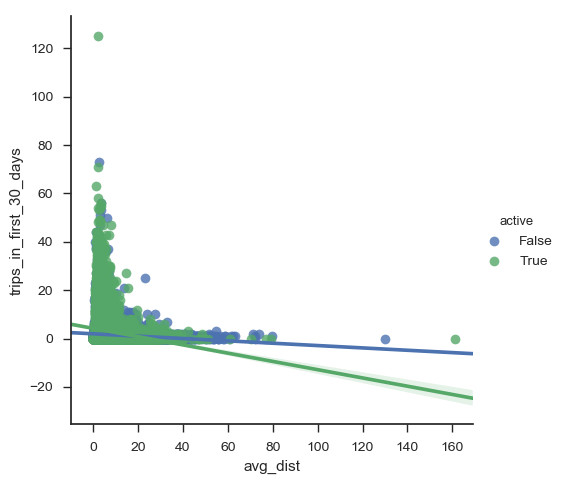

In [22]:
sns.lmplot(x = 'avg_dist', y = 'trips_in_first_30_days', hue='active', data=data)

(-1, 11)

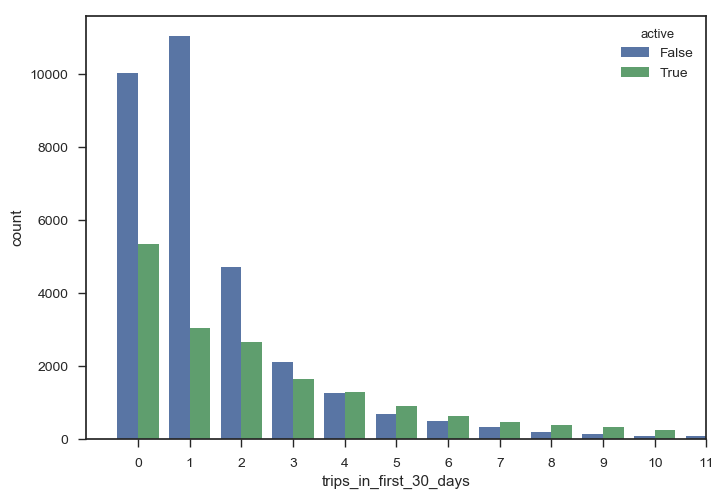

In [23]:
sns.countplot(x='trips_in_first_30_days', data=data, hue='active')
plt.xlim((-1, 11))

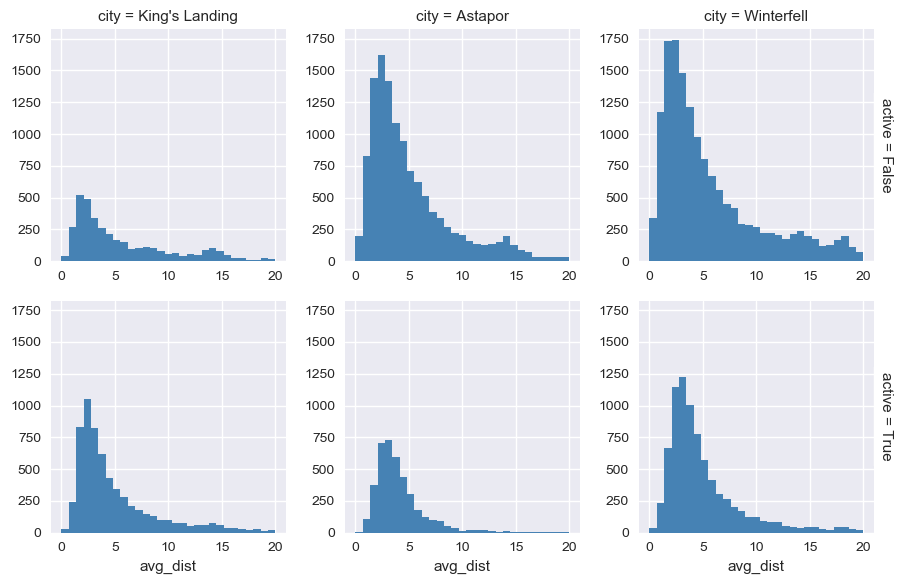

In [24]:
sns.set(style="darkgrid")
g = sns.FacetGrid(data, row="active", col="city", margin_titles=True)
bins = np.linspace(0, 20, 30)
g.map(plt.hist, "avg_dist", color="steelblue", bins=bins, lw=0)

In [25]:
cat_columns = data.select_dtypes(['object']).columns
data[cat_columns] = data[cat_columns].apply(lambda col: pd.factorize(col, sort=True)[0])
data.active = data.active.astype("int")
data.ultimate_black_user = data.ultimate_black_user.astype("int")
#data['last_trip_day'] = data.last_trip_date.dt.day
#data['last_trip_month'] = data.last_trip_date.dt.month
data = data.drop(["signup_date","last_trip_date"], axis=1)

In [26]:
data.avg_rating_by_driver = data.avg_rating_by_driver.fillna(np.mean(data.avg_rating_by_driver))
data.avg_rating_of_driver = data.avg_rating_of_driver.fillna(np.mean(data.avg_rating_of_driver))

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 11 columns):
avg_dist                  49992 non-null float64
avg_rating_by_driver      49992 non-null float64
avg_rating_of_driver      49992 non-null float64
avg_surge                 49992 non-null float64
city                      49992 non-null int64
phone                     49992 non-null int64
surge_pct                 49992 non-null float64
trips_in_first_30_days    49992 non-null int64
ultimate_black_user       49992 non-null int32
weekday_pct               49992 non-null float64
active                    49992 non-null int32
dtypes: float64(6), int32(2), int64(3)
memory usage: 5.4 MB


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler

In [29]:
# Train and test sets
x = data.drop(['active'], axis=1)
y = data['active']

# feature scaling
scaler = MinMaxScaler()
scaler.fit(x)
scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.03, stratify=y)

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

In [30]:
x.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'phone', 'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct'],
      dtype='object')

In [31]:
# score
print('Feature importance of the 3 features')
features = x.columns

print('=====Feature importance=======')
for idx, val in enumerate(clf.feature_importances_):
    print("{:20}{:3f}".format(features[idx], val))
print('-----------------------------------------------')

print("{:20}{:3f}".format('F1 score', f1_score(y_test, y_pred)))
print("{:20}{:3f}".format('Test accuracy', accuracy_score(y_test, y_pred)))
print()

print('====Confusion Matrix=====')
print(confusion_matrix(y_test, y_pred))

Feature importance of the 3 features
=====Feature importance=======
avg_dist            0.312247
avg_rating_by_driver0.177084
avg_rating_of_driver0.080271
avg_surge           0.041645
city                0.077826
phone               0.042013
surge_pct           0.065581
trips_in_first_30_days0.065550
ultimate_black_user 0.026299
weekday_pct         0.111483
-----------------------------------------------
F1 score            0.609665
Test accuracy       0.720000

====Confusion Matrix=====
[[752 199]
 [221 328]]
